In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb

from sklearn.ensemble import BaggingRegressor, VotingRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression

from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV, StratifiedKFold
from sklearn.utils.validation import has_fit_parameter


import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import make_pipeline
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import BaggingRegressor, StackingRegressor
from sklearn.model_selection import train_test_split
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.linear_model import Ridge


In [2]:
df=pd.read_csv(r'北北桃5_filter_outlier.csv')
#df = df[df['縣市'] == '台北市']
country_name='北北桃'

In [3]:
df.info(max_cols=121)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568306 entries, 0 to 568305
Data columns (total 92 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   編號                  568306 non-null  object 
 1   交易年月日               568306 non-null  object 
 2   年_西元                568306 non-null  int64  
 3   年_民國                568306 non-null  int64  
 4   月                   568306 non-null  int64  
 5   縣市                  568306 non-null  object 
 6   鄉鎮市區                568306 non-null  object 
 7   土地位置建物門牌            568306 non-null  object 
 8   交易標的                568306 non-null  object 
 9   土地移轉總面積平方公尺         568306 non-null  float64
 10  都市土地使用分區            568306 non-null  object 
 11  主要用途                568306 non-null  object 
 12  主要建材                568306 non-null  object 
 13  建築完成年月              568179 non-null  object 
 14  建物移轉總面積平方公尺         568306 non-null  float64
 15  總價元                 568306 non-nul

In [4]:
# 確保日期欄位轉換為日期格式
df['交易年月日'] = pd.to_datetime(df['交易年月日'])
df.set_index('交易年月日', inplace=True)



In [5]:
# 分割資料為訓練集、測試集
# 提取 2024-01-01 以前的資料作為訓練集

train_df = df[df.index <= '2023-12-31']
test_df = df[(df.index > '2023-12-31') & (df.index < '2024-08-31')]

In [6]:
# 確認分割結果
print(f"訓練和測試集數據量: {train_df.shape}")
print(f"驗證集數據量: {test_df.shape}")
print(f"全部數據量: {df.shape}")

訓練和測試集數據量: (524160, 91)
驗證集數據量: (44146, 91)
全部數據量: (568306, 91)


In [7]:
# 切割資料為訓練、測試


X_train = train_df.drop(['編號', '總價元', '單價元平方公尺',
                                   '建築完成年月', '土地位置建物門牌', '建物移轉總面積平方公尺',
                                    '交易標的', '都市土地使用分區', 
                                   '備註', '移轉層次', '總樓層數','單價元/坪','嫌惡設施_500內','嫌惡設施_500到1000','學校_500內','學校_500到1000','公園_500內','公園_500到1000','公車站_500內','公車站_500到1000','捷運站_500內','捷運站_500到1000','建物現況格局-房','建物現況格局-廳','建物現況格局-衛'], axis=1)
y_train = train_df['單價元/坪']

X_test = test_df.drop(['編號', '總價元', '單價元平方公尺',
                                   '建築完成年月', '土地位置建物門牌', '建物移轉總面積平方公尺',
                                    '交易標的', '都市土地使用分區', 
                                   '備註', '移轉層次', '總樓層數','單價元/坪','嫌惡設施_500內','嫌惡設施_500到1000','學校_500內','學校_500到1000','公園_500內','公園_500到1000','公車站_500內','公車站_500到1000','捷運站_500內','捷運站_500到1000','建物現況格局-房','建物現況格局-廳','建物現況格局-衛'], axis=1)
y_test = test_df['單價元/坪']

In [8]:
#'土地移轉總面積平方公尺','車位移轉總面積平方公尺','總使用面積','主建物面積','車位總價元','附屬建物面積','陽台面積',

In [9]:
from sklearn.preprocessing import StandardScaler
# 确定 one-hot encoding 的欄位範圍
one_hot_cols = ['鄉鎮市區', '主要用途', '主要建材', '車位類別', '建物型態', '縣市']

# 取出 one-hot encoding 的欄位
X_train_one_hot = X_train[one_hot_cols]
X_test_one_hot = X_test[one_hot_cols]

# 取出非 one-hot encoding 的欄位，即連續型變數
continuos_col_name = X_train.drop(columns=X_train_one_hot.columns).select_dtypes(include=['number']).columns
X_train_continuos = X_train[continuos_col_name]
X_test_continuos = X_test[continuos_col_name]

# 标准化连续型变量
scaler = StandardScaler()
X_train_continuos_scaled = scaler.fit_transform(X_train_continuos)
X_test_continuos_scaled = scaler.transform(X_test_continuos)

# 将标准化后的 NumPy 数组转换回 DataFrame，并保留索引
X_train_continuos_scaled = pd.DataFrame(X_train_continuos_scaled, index=X_train.index, columns=continuos_col_name)
X_test_continuos_scaled = pd.DataFrame(X_test_continuos_scaled, index=X_test.index, columns=continuos_col_name)

# 进行 One-Hot Encoding
X_train_one_hot_encoded = pd.get_dummies(X_train_one_hot, drop_first=True)
X_test_one_hot_encoded = pd.get_dummies(X_test_one_hot, drop_first=True)

# 确保训练和测试集的列一致
X_train_one_hot_encoded, X_test_one_hot_encoded = X_train_one_hot_encoded.align(X_test_one_hot_encoded, join='outer', axis=1, fill_value=0)

# 合并标准化后的连续型变量与 one-hot encoding 的欄位
X_train_final = pd.concat([X_train_continuos_scaled, X_train_one_hot_encoded], axis=1)
X_test_final = pd.concat([X_test_continuos_scaled, X_test_one_hot_encoded], axis=1)


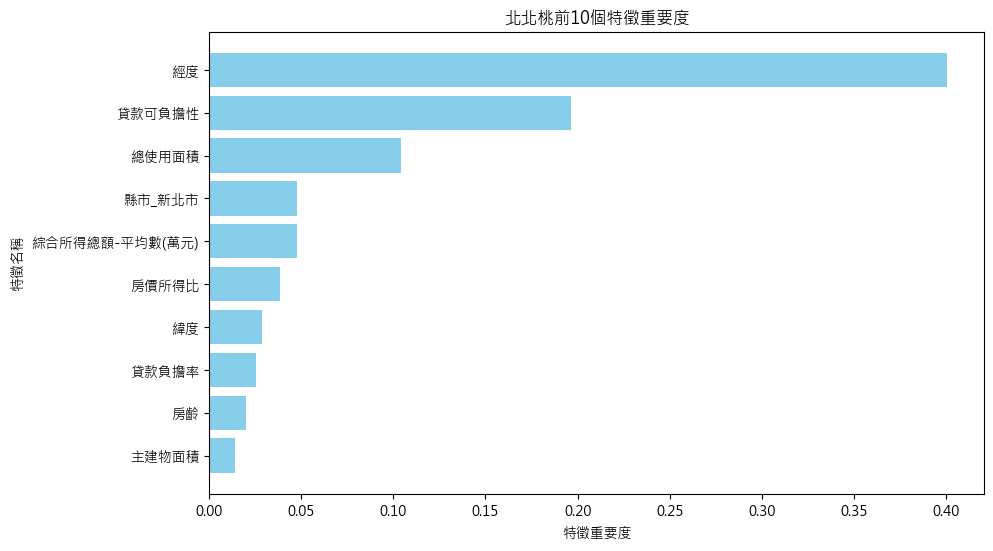

In [10]:
plt.rcParams['font.family'] = 'Microsoft JhengHei'
plt.rcParams['axes.unicode_minus'] = False  


rf_model = RandomForestRegressor()
rf_model.fit(X_train_final, y_train)


feature_importances = rf_model.feature_importances_
feature_names = list(continuos_col_name) + list(X_train_one_hot_encoded.columns)


feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})


top_features = feature_importance_df.sort_values(by='Importance', ascending=False).head(10)
top_feature_names = top_features['Feature'].tolist()


def plot_feature_importance(importance, feature_names,model_name):
    indices = np.argsort(importance)[::-1]
    sorted_feature_names = [feature_names[i] for i in indices]
    sorted_importance = importance[indices]

 
    top_n = 10
    top_feature_names = sorted_feature_names[:top_n]
    top_importance = sorted_importance[:top_n]

 
    plt.figure(figsize=(10, 6))
    plt.barh(top_feature_names, top_importance, color='skyblue')
    plt.xlabel('特徵重要度')
    plt.ylabel('特徵名稱')
    plt.title(f'{country_name}前{top_n}個特徵重要度')
    plt.gca().invert_yaxis() 
    filename = f'C:\\Users\\student\\Desktop\\額外資料分類\\結果圖片\\{country_name}前{top_n}個特徵重要度.png'
    plt.savefig(filename)
    plt.show()



top_feature_indices = [feature_names.index(name) for name in top_feature_names]


X_train_top = X_train_final[top_feature_names]  
X_test_top = X_test_final[top_feature_names]    


plot_feature_importance(feature_importances, feature_names, 'Random Forest')

In [11]:


def evaluate_model(models, X_train_top, y_train, X_test_top, y_test, train_df, test_df, country_name):
    for name, model in models.items():
        print(f"Evaluating {name}")
        print("-" * 50)

        # Train the model
        model.fit(X_train_top, y_train)

        # Predict on training and test sets
        y_pred_train = model.predict(X_train_top)
        y_pred_test = model.predict(X_test_top)

        # Calculate mean squared error
        mse_train = mean_squared_error(y_train, y_pred_train)
        mse_test = mean_squared_error(y_test, y_pred_test)

        # Calculate mean absolute error
        mae_train = mean_absolute_error(y_train, y_pred_train)
        mae_test = mean_absolute_error(y_test, y_pred_test)

        # Calculate R²
        r2_train = r2_score(y_train, y_pred_train)
        r2_test = r2_score(y_test, y_pred_test)

        # Calculate RMSE
        rmse_train = np.sqrt(mse_train)
        rmse_test = np.sqrt(mse_test)

        # Prepare the results for train and test
        test_results = pd.DataFrame({
            '交易年月日': X_test_top.index,
            '單價元/坪預測值': y_pred_test
        })
        train_results = pd.DataFrame({
            '交易年月日': X_train_top.index,
            '單價元/坪預測值': y_pred_train
        })

        # Merge train and test results
        combined_results = pd.concat([train_results, test_results])

        # Convert the date column to datetime
        combined_results['交易年月日'] = pd.to_datetime(combined_results['交易年月日'])
        combined_results.set_index('交易年月日', inplace=True)

        # Group by month and calculate average predicted prices
        monthly_avg_predicted_prices = combined_results.resample('M').mean()

        # Plot the predicted house prices each month
        plt.figure(figsize=(10, 6))
        plt.plot(monthly_avg_predicted_prices.index, monthly_avg_predicted_prices['單價元/坪預測值'], marker='o', label='Predicted')

        # Prepare the actual values for train and test
        train_df['交易年月日'] = pd.to_datetime(train_df.index)
        test_df['交易年月日'] = pd.to_datetime(test_df.index)

        combined_actual = pd.concat([train_df[['交易年月日', '單價元/坪']], test_df[['交易年月日', '單價元/坪']]])
        combined_actual.set_index('交易年月日', inplace=True)
        monthly_avg_actual_prices = combined_actual.resample('M').mean()

        # Plot actual values
        plt.plot(monthly_avg_actual_prices.index, monthly_avg_actual_prices['單價元/坪'], marker='o', label='Actual')

        # Add labels and title
        plt.xlabel('年')
        plt.ylabel('單價元/坪')
        plt.title(f'{country_name} 平均單價元/坪 ({name})')
        plt.legend()
        plt.grid(True)

        # Metrics text for train and test
        metrics_text_train = (f"MSE (Train): {mse_train:.2f}\n"
                              f"MAE (Train): {mae_train:.2f}\n"
                              f"RMSE (Train): {rmse_train:.2f}\n"
                              f"R² (Train): {r2_train:.2f}")

        metrics_text_test = (f"MSE (Test): {mse_test:.2f}\n"
                             f"MAE (Test): {mae_test:.2f}\n"
                             f"RMSE (Test): {rmse_test:.2f}\n"
                             f"R² (Test): {r2_test:.2f}")

        # Add metrics text to the plot
        plt.text(0.05, 0.95, metrics_text_train, transform=plt.gca().transAxes,
                 fontsize=10, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))

        plt.text(0.05, 0.65, metrics_text_test, transform=plt.gca().transAxes,
                 fontsize=10, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))

        # Save the plot to file
        filename = f'C:\\Users\\student\\Desktop\\額外資料分類\\結果圖片\\{name}{country_name}平均每坪價格.png'
        plt.savefig(filename)
        plt.show()



Evaluating XGBoost
--------------------------------------------------


C:\Users\student\AppData\Local\Temp\ipykernel_6136\639384655.py:47: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_avg_predicted_prices = combined_results.resample('M').mean()
C:\Users\student\AppData\Local\Temp\ipykernel_6136\639384655.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['交易年月日'] = pd.to_datetime(train_df.index)
C:\Users\student\AppData\Local\Temp\ipykernel_6136\639384655.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

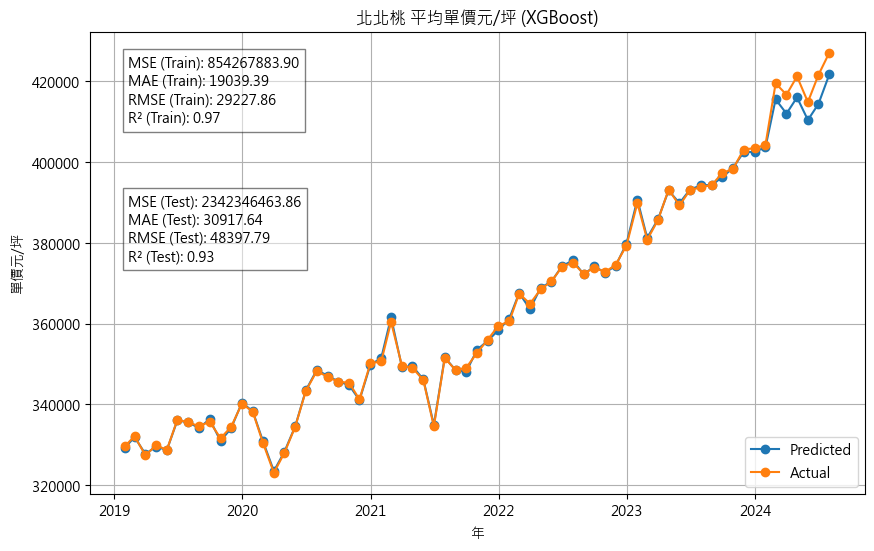

Evaluating CatBoost
--------------------------------------------------


C:\Users\student\AppData\Local\Temp\ipykernel_6136\639384655.py:47: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_avg_predicted_prices = combined_results.resample('M').mean()
C:\Users\student\AppData\Local\Temp\ipykernel_6136\639384655.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['交易年月日'] = pd.to_datetime(train_df.index)
C:\Users\student\AppData\Local\Temp\ipykernel_6136\639384655.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

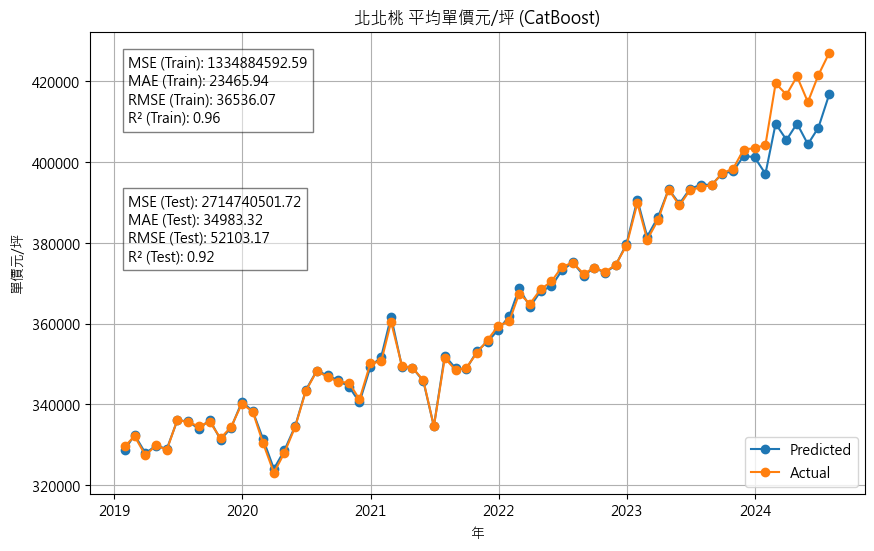

Evaluating LightGBM
--------------------------------------------------


C:\Users\student\AppData\Local\Temp\ipykernel_6136\639384655.py:47: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_avg_predicted_prices = combined_results.resample('M').mean()
C:\Users\student\AppData\Local\Temp\ipykernel_6136\639384655.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['交易年月日'] = pd.to_datetime(train_df.index)
C:\Users\student\AppData\Local\Temp\ipykernel_6136\639384655.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

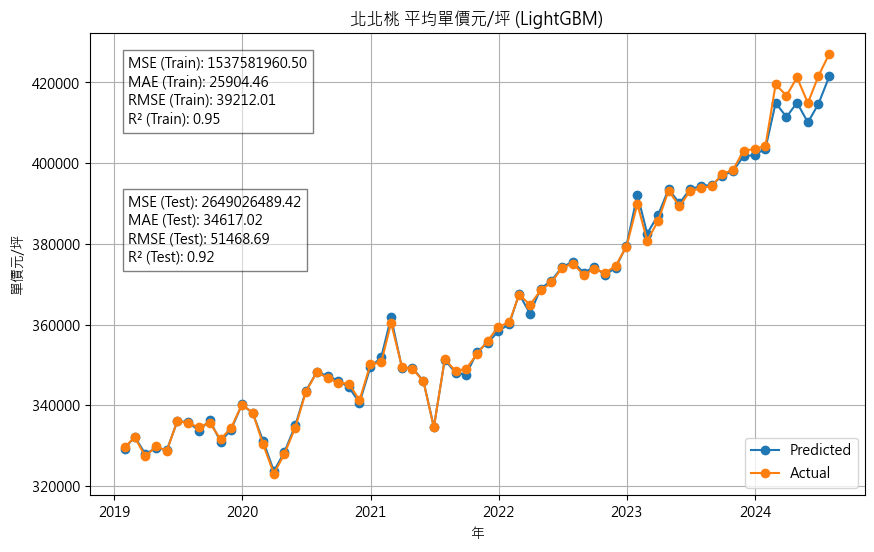

In [12]:
base_models = {
    "XGBoost": xgb.XGBRegressor(n_estimators=194, max_depth=9, learning_rate=0.14561791429562515, 
                                 reg_alpha=0.1, reg_lambda=0.1, random_state=42),
    "CatBoost": CatBoostRegressor(iterations=200, depth=10, learning_rate=0.26973961642361094, 
                                   loss_function='RMSE', random_seed=42, verbose=0),
    "LightGBM": LGBMRegressor(n_estimators=197, max_depth=9, learning_rate=0.1876517568147882, 
                               random_state=42, verbose=-1)
}

# 評估模型
evaluate_model(base_models, X_train_top, y_train, X_test_top, y_test, train_df, test_df, country_name)



In [24]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

# 定義基礎模型
base_models = [
    ('XGBoost', xgb.XGBRegressor(n_estimators=403, max_depth=12, learning_rate=0.068,
                                  reg_alpha=0.136, reg_lambda=0.887)),
    ('CatBoost', CatBoostRegressor(iterations=346, depth=10, learning_rate=0.264,
                                   l2_leaf_reg=0.344, verbose=0)),
    ('LightGBM', LGBMRegressor(n_estimators=478, max_depth=8, learning_rate=0.296,
                                lambda_l1=0.775, lambda_l2=0.683))
]

# 堆疊模型
stacking_model = StackingRegressor(
    estimators=base_models,
    final_estimator=LinearRegression(),
    passthrough=False
)


# 訓練堆疊模型
stacking_model.fit(X_train_top, y_train)

# 預測
y_pred_train = stacking_model.predict(X_train_top)
y_pred_test = stacking_model.predict(X_test_top)

# 計算 RMSE
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")


Train RMSE: 23272.20989913779
Test RMSE: 46845.25393116267


In [14]:
from sklearn.model_selection import cross_val_score

# 使用 5 折交叉驗證評估堆疊模型
cv_scores = cross_val_score(stacking_model, X_train_top, y_train, cv=5, scoring='neg_mean_squared_error')

# 取平均 RMSE
cv_rmse = np.sqrt(-cv_scores.mean())
print(f"Cross-Validation RMSE: {cv_rmse}")


Cross-Validation RMSE: 38616.77829263611


In [15]:
import optuna
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# 定義目標函數
def objective_xgb(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 1.0),
        'random_state': 42
    }
    
    # 使用定義的超參數來訓練模型
    model = xgb.XGBRegressor(**param)
    model.fit(X_train_top, y_train)

    # 預測和計算 RMSE
    y_pred = model.predict(X_test_top)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    
    return rmse

# 創建一個 Optuna study 來優化
study_xgb = optuna.create_study(direction='minimize')
study_xgb.optimize(objective_xgb, n_trials=50)

# 獲取最佳參數
best_params_xgb = study_xgb.best_params
print("Best XGBoost params:", best_params_xgb)


[I 2024-10-24 14:42:44,361] A new study created in memory with name: no-name-2278418d-4d16-439c-9341-c7de9b1e44d9
c:\Users\student\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-10-24 14:42:45,172] Trial 0 finished with value: 56555.54094607877 and parameters: {'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.24479290416123015, 'reg_alpha': 0.38950597371933016, 'reg_lambda': 0.9476809863408204}. Best is trial 0 with value: 56555.54094607877.
c:\Users\student\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-10-24

Best XGBoost params: {'n_estimators': 403, 'max_depth': 12, 'learning_rate': 0.06834992427397471, 'reg_alpha': 0.13640051912460865, 'reg_lambda': 0.8874578272001568}


In [21]:
from catboost import CatBoostRegressor

def objective_cat(trial):
    param = {
        'iterations': trial.suggest_int('iterations', 100, 500),
        'depth': trial.suggest_int('depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.01, 10.0),
        'random_seed': 42
    }
    
    model = CatBoostRegressor(**param, verbose=0)
    model.fit(X_train_top, y_train)

    y_pred = model.predict(X_test_top)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    
    return rmse

study_cat = optuna.create_study(direction='minimize')
study_cat.optimize(objective_cat, n_trials=50)

best_params_cat = study_cat.best_params
print("Best CatBoost params:", best_params_cat)





[I 2024-10-24 14:52:28,447] A new study created in memory with name: no-name-0dc0865d-cde1-4fb9-b167-f2829aa7f6af
c:\Users\student\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.

[I 2024-10-24 14:52:37,133] Trial 0 finished with value: 50628.97737448459 and parameters: {'iterations': 399, 'depth': 8, 'learning_rate': 0.26052227512452225, 'l2_leaf_reg': 4.332805065504223}. Best is trial 0 with value: 50628.97737448459.
c:\Users\student\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.

[I 2024-10-24 14:52:40,010] Trial 1 finished with value: 57360.937569700305 and par

Best CatBoost params: {'iterations': 346, 'depth': 10, 'learning_rate': 0.2640196711012997, 'l2_leaf_reg': 0.3437297501993557}


In [22]:
from lightgbm import LGBMRegressor

def objective_lgbm(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'lambda_l1': trial.suggest_float('lambda_l1', 0.01, 1.0),
        'lambda_l2': trial.suggest_float('lambda_l2', 0.01, 1.0),
        'random_state': 42
    }

    model = LGBMRegressor(**param)
    model.fit(X_train_top, y_train)

    y_pred = model.predict(X_test_top)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    
    return rmse

study_lgbm = optuna.create_study(direction='minimize')
study_lgbm.optimize(objective_lgbm, n_trials=50)

best_params_lgbm = study_lgbm.best_params
print("Best LightGBM params:", best_params_lgbm)


[I 2024-10-24 15:06:56,987] A new study created in memory with name: no-name-44ed7eec-b382-4d2b-9116-6b2cc80a8946
c:\Users\student\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.

[I 2024-10-24 15:06:58,416] Trial 0 finished with value: 51373.86076660993 and parameters: {'n_estimators': 243, 'max_depth': 9, 'learning_rate': 0.2504658456173607, 'lambda_l1': 0.4110203737333232, 'lambda_l2': 0.4668882092368439}. Best is trial 0 with value: 51373.86076660993.
c:\Users\student\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.

[I 2024-10-24 15:06:59,863] Trial 1 finished w

Best LightGBM params: {'n_estimators': 478, 'max_depth': 8, 'learning_rate': 0.29616823563941735, 'lambda_l1': 0.7751291059988912, 'lambda_l2': 0.6829814414759826}


In [23]:
# 最佳試驗的參數
print(study_xgb.best_params)
print(study_cat.best_params)
print(study_lgbm.best_params)

{'n_estimators': 403, 'max_depth': 12, 'learning_rate': 0.06834992427397471, 'reg_alpha': 0.13640051912460865, 'reg_lambda': 0.8874578272001568}
{'iterations': 346, 'depth': 10, 'learning_rate': 0.2640196711012997, 'l2_leaf_reg': 0.3437297501993557}
{'n_estimators': 478, 'max_depth': 8, 'learning_rate': 0.29616823563941735, 'lambda_l1': 0.7751291059988912, 'lambda_l2': 0.6829814414759826}


In [25]:
from sklearn.metrics import r2_score
# 計算訓練集 R²
train_r2 = r2_score(y_train, y_pred_train)

# 計算測試集 R²
test_r2 = r2_score(y_test, y_pred_test)

# 輸出 R² 值
print(f"Train R²: {train_r2}")
print(f"Test R²: {test_r2}")

Train R²: 0.9819890965690263
Test R²: 0.93512248804175
